In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prashant268/chest-xray-covid19-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.06G/2.06G [00:27<00:00, 79.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2


In [3]:
import os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50

import cv2

In [4]:
directory ="{}/Data/train".format(path)

directory, os.listdir(directory)

('/root/.cache/kagglehub/datasets/prashant268/chest-xray-covid19-pneumonia/versions/2/Data/train',
 ['COVID19', 'PNEUMONIA', 'NORMAL'])

In [5]:
img_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [6]:
train_gen = img_gen.flow_from_directory(directory, target_size=(256,256), batch_size=40, class_mode='categorical', subset='training')

Found 4116 images belonging to 3 classes.


In [7]:
validation_gen = img_gen.flow_from_directory(directory, target_size=(256,256), batch_size=40, class_mode='categorical', subset='validation')


Found 1028 images belonging to 3 classes.


In [8]:
train_images, train_labels = next(train_gen)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 3)

In [11]:
train_labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [12]:
label_names = {0:"PNEUMONIA", 1:"NORMAL",2:"COVID19" }

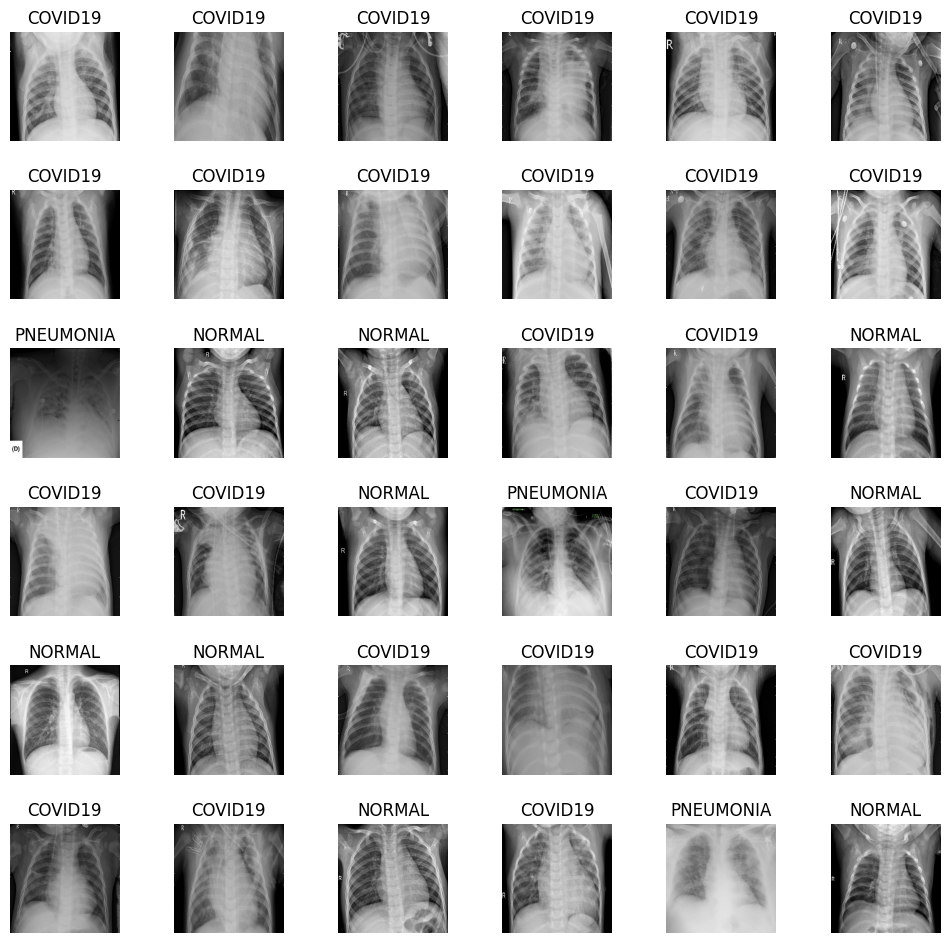

In [13]:
L=6
W=6

fig, axes = plt.subplots(L, W, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, L*W):
  axes[i].imshow(train_images[i])
  axes[i].set_title(label_names[np.argmax(train_labels[i])])
  axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)



In [14]:
basemodel= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
for layer in basemodel.layers[:-10]:
  layers.trainable =False

In [17]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel = Flatten(name='flatten')(headmodel)
headmodel = Dense(256, activation='relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation='relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(3, activation='softmax')(headmodel)

In [18]:
model = Model(inputs=basemodel.input, outputs=headmodel)

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['accuracy'])

In [20]:
early_stopping = EarlyStopping(monitor='val_loss',mode="min", patience=20, verbose=1)

In [21]:
checkpointer = ModelCheckpoint(filepath='model.h5', verbose=1, save_best_only=True)

In [23]:
history = model.fit(train_gen,steps_per_epoch=train_gen.n, epochs=5, validation_data=validation_gen,validation_steps=validation_gen.n, callbacks=[early_stopping, checkpointer])

Epoch 1/5
 103/4116 ━━━━━━━━━━━━━━━━━━━━ 42:53:03 38s/step - accuracy: 0.9507 - loss: 0.1390

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 2.08384, saving model to model.h5


4116/4116 ━━━━━━━━━━━━━━━━━━━━ 4189s 1s/step - accuracy: 0.9540 - loss: 0.1343 - val_accuracy: 0.6644 - val_loss: 2.0838
Epoch 2/5
 103/4116 ━━━━━━━━━━━━━━━━━━━━ 43:08:41 39s/step - accuracy: 0.9864 - loss: 0.0426
Epoch 2: val_loss improved from 2.08384 to 1.25931, saving model to model.h5


4116/4116 ━━━━━━━━━━━━━━━━━━━━ 4242s 1s/step - accuracy: 0.9819 - loss: 0.0543 - val_accuracy: 0.6255 - val_loss: 1.2593
Epoch 3/5
 103/4116 ━━━━━━━━━━━━━━━━━━━━ 42:39:07 38s/step - accuracy: 0.9841 - loss: 0.0401
Epoch 3: val_loss did not improve from 1.25931
4116/4116 ━━━━━━━━━━━━━━━━━━━━ 4175s 1s/step - accuracy: 0.9825 - loss: 0.0498 - val_accuracy: 0.1265 - val_loss: 2.2337
Epoch 4/5
 103/4116 ━━━━━━━━━━━━━━━━━━━━ 42:42:09 38s/step - accuracy: 0.9956 - loss: 0.0163
Epoch 4: val_loss did not improve from 1.25931
4116/4116 ━━━━━━━━━━━━━━━━━━━━ 4166s 1s/step - accuracy: 0.9940 - loss: 0.0200 - val_accuracy: 0.0895 - val_loss: 5.1095
Epoch 5/5
 103/4116 ━━━━━━━━━━━━━━━━━━━━ 42:39:03 38s/step - accuracy: 0.9928 - loss: 0.0215
Epoch 5: val_loss did not improve from 1.25931
4116/4116 ━━━━━━━━━━━━━━━━━━━━ 4217s 1s/step - accuracy: 0.9920 - loss: 0.0241 - val_accuracy: 0.0895 - val_loss: 6.9140


In [24]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

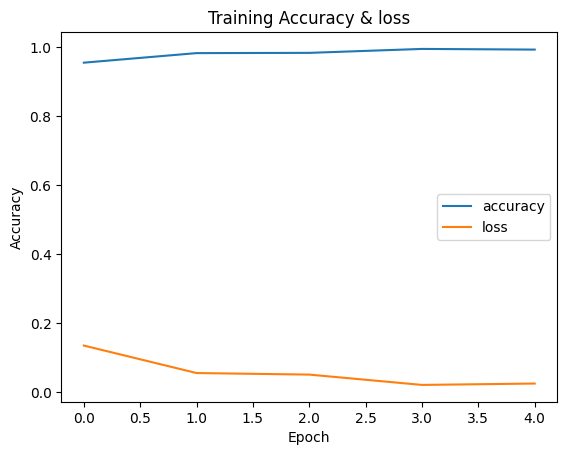

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.title('Training Accuracy & loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

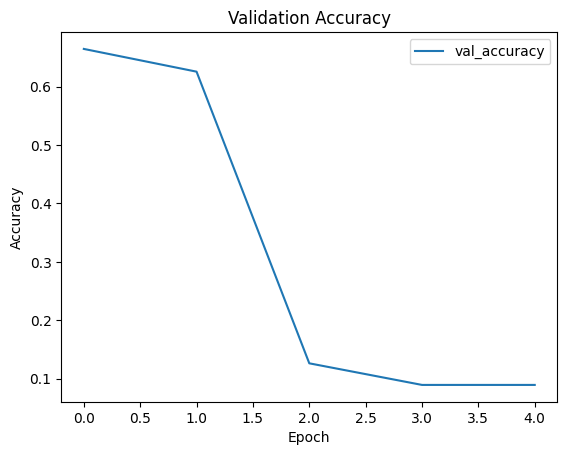

In [26]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

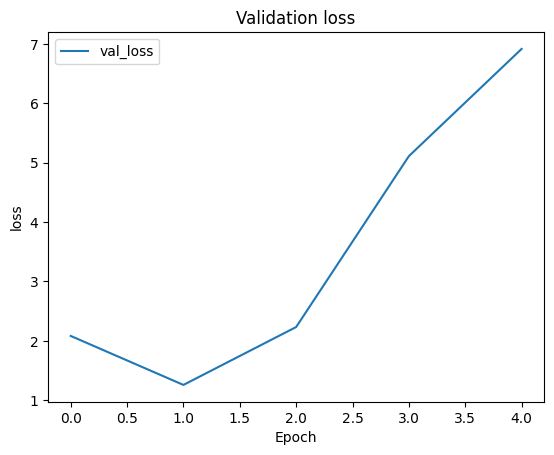

In [27]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [29]:
test_directory ="{}/Data/test".format(path)

test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate(test_generator, steps = test_generator.n, verbose =1)

Found 1288 images belonging to 3 classes.
1288/1288 ━━━━━━━━━━━━━━━━━━━━ 275s 206ms/step - accuracy: 0.0899 - loss: 7.3509
